# **What genres do the best in theatres?**
- Motivation:
    - Creating movies in popular genres will attract more initial viewers. It’s what the people are interested in watching.


**Smaller questions:**
- Which genres normally tend to be well received by the audience?
- Which genre is the least lucrative? And the most?
    - Which movie had the best investment return ratio? And which Genres are constantly doing well?

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

Assign all the CSV files to something and add comments to it

In [8]:
# Titles, Studio, Domestic Gross, Foreign Gross and Year
# 3387 rows
movies_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
# Nconst, Primary Name, Primary Profession, Known for titles(title_id)
# 606648 rows
basics_names = pd.read_csv("zippedData/name.basics.csv")
# ID's, Ordering, Title, Region, Language, Types, Attributes, Original Title
# 331703 rows
akas = pd.read_csv("zippedData/title.akas.csv")
# Tconst, Primary Title, Original Title, Start Year, Runtime Minutes, Genres
# 146144 rows
basics_titles = pd.read_csv("zippedData/title.basics.csv")
# Tconst, Directors, Writers
# 146144 rows
crew = pd.read_csv("zippedData/title.crew.csv")
# Tconst, Ordering, Nconst, Category, Job, Characters
# 1028186 rows
principals = pd.read_csv("zippedData/title.principals.csv")
# Tconst, Average Rating, Number of Votes
# 73856 rows
ratings = pd.read_csv("zippedData/title.ratings.csv")
# Genre Id, Id, Original Language, Original Language, Original Title, Popularity, Release Date, Title, Vote Average, Vote count 
# 26517 rows
movies = pd.read_csv("zippedData/tmdb.movies.csv")
# Id, Release Date, Movie Name, Budget, Domestic Gross, Worldwide Gross
# 5782 rows
movies_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv")


Assign all the TSV files to something and add comments to it

In [9]:
#Id, Synopsis, Rating, Genre, Director, Writer, Theater Date, Dvd Date, Currency, Box Office, Runtime, Studio
#1560 rows 
movie_info = pd.read_csv("zippedData/rt.movie_info.tsv", sep='\t')
#Id, Reviews, Rating, Fresh, Critic, Top Critic, Publisher, Date
#54432 rows
reviews = pd.read_csv("zippedData/rt.reviews.tsv", sep='\t', encoding = 'unicode_escape')


# Working with data

### Working with the basics_titles dataframe

Creating a table that contains Titles, Genres, Start Year and Tconst.

In [11]:
# Clean basics_titles to only those released after 2008 and before 2020
# Clean NAN rows, since they didn't have the most important information for this analysis, the genre
# Drop the columns

basics_titles = basics_titles[basics_titles['start_year'] > 2008]
basics_titles = basics_titles[basics_titles['start_year'] <= 2019]
title_genre = basics_titles.drop(['original_title', 'runtime_minutes'], axis=1)
title_genre.dropna(inplace=True)


In [14]:
title_genre.head(2)

,tconst,primary_title,start_year,genres
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama"


Creating a new table with the rating, tconst, primary_title and genre.

In [19]:
# Join tables to create a new one with more info
# Drop NAN values, since they didn't have the most important information for this analysis, the genre

titlegenrerating = ratings.join(title_genre.set_index('tconst'), on='tconst')
titlegenrerating.dropna(inplace=True)

In [10]:
titlegenrerating.head(2)

,tconst,averagerating,numvotes,primary_title,start_year,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,2019.0,Romance
1,tt10384606,8.9,559,Borderless,2019.0,Documentary


# Working with the movies_budgets dataframe

The goal here is to create a table with Movies Name, Budget, Domestic Gross and Worldwide Gross(Cleaning the column ID)

In [21]:
# Drop columns that we are not going to use
# Rename Column to match the other table, to make left-join possible

movies_money = movies_budgets.drop(['id', 'release_date'], axis=1)
movies_money.rename(columns={"movie": "primary_title"}, inplace=True)

In [12]:
#5782 rows
movies_money.head(2)

,primary_title,production_budget,domestic_gross,worldwide_gross
0,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [13]:
# Using method str.replace to remove ',' and '$' from the data columns 
# Using astype to change the values in those columns from String to Float because to Int gives an error

movies_money['worldwide_gross'] = movies_money['worldwide_gross'].str.replace(',', '')
movies_money['worldwide_gross'] = movies_money['worldwide_gross'].str.replace('$', '')
movies_money['worldwide_gross'] = movies_money['worldwide_gross'].astype(float)

movies_money['production_budget'] = movies_money['production_budget'].str.replace(',', '')
movies_money['production_budget'] = movies_money['production_budget'].str.replace('$', '')
movies_money['production_budget'] = movies_money['production_budget'].astype(float)

movies_money['domestic_gross'] = movies_money['domestic_gross'].str.replace(',', '')
movies_money['domestic_gross'] = movies_money['domestic_gross'].str.replace('$', '')
movies_money['domestic_gross'] = movies_money['domestic_gross'].astype(float)


In [14]:
# Create a new column to give the investment return (How many dollars you get per dollar invested)
# Check for duplicated entries on the data based on the primary title column q
# Drop all the duplicates, not keeping any so it doesn't conflict with the other table and we get false information
# Check one last time to see if we still have duplicates

movies_money['investment_return'] = movies_money['worldwide_gross']/movies_money['production_budget']
movies_money['investment_return'] = movies_money['investment_return'] - 1

duplicates_money = movies_money[movies_money.duplicated(subset=['primary_title'],keep=False)].sort_values(['primary_title'])

movies_money.drop_duplicates(subset='primary_title', inplace=True)


In [15]:
movies_money.head(2)

,primary_title,production_budget,domestic_gross,worldwide_gross,investment_return
0,Avatar,425000000.0,760507625.0,2.776345e+09,5.532577
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.546673


# Creating the new table moviesfullinfo

The idea here is to join two tables to make one with ratings and money to make mostly a correlation between these 2 metrics

In [16]:
# Drop Tconst, since this one is supposed to be the final table to use for graphs
# Drop nan's values
# Creat a filter to only movies that had a budget over a million dollars

# new_df = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])

moviesfullinfo = movies_money.join(titlegenrerating.set_index('primary_title'), on='primary_title')
#moviesfullinfo = pd.merge(titlegenrerating, movies_money, how='left', on=['primary_title', 'primary_title'])
moviesfullinfo.drop(['tconst'], axis=1, inplace=True)
moviesfullinfo = moviesfullinfo.dropna()
moviesfullinfo = moviesfullinfo[moviesfullinfo['production_budget'] >= 1000000]
moviesfullinfo = moviesfullinfo[moviesfullinfo['worldwide_gross'] >= 1]
moviesfullinfo.drop_duplicates(subset='primary_title', inplace=True)

In [17]:
#2410 rows

moviesfullinfo.sort_values(['investment_return'])

,primary_title,production_budget,domestic_gross,worldwide_gross,investment_return,averagerating,numvotes,start_year,genres
5302,American Hero,1000000.0,0.0,26.0,-0.999974,4.9,3661.0,2015.0,"Action,Comedy,Drama"
3818,Skin Trade,9000000.0,1242.0,1242.0,-0.999862,5.7,6942.0,2014.0,"Action,Crime,Thriller"
3161,Broken Horses,15000000.0,0.0,3471.0,-0.999769,5.7,1957.0,2015.0,"Action,Crime,Drama"
4103,Tracker,6500000.0,0.0,3149.0,-0.999516,6.5,3460.0,2010.0,"Action,Adventure,Drama"
2480,Molly,21000000.0,17396.0,17396.0,-0.999172,4.6,726.0,2017.0,"Action,Sci-Fi"
...,...,...,...,...,...,...,...,...,...
4664,Paranormal Activity 2,3000000.0,84752907.0,177512032.0,58.170677,5.7,93122.0,2010.0,Horror
5213,Unfriended,1000000.0,32789645.0,64364198.0,63.364198,5.6,62043.0,2014.0,"Horror,Mystery,Thriller"
5062,Insidious,1500000.0,54009150.0,99870886.0,65.580591,6.9,254197.0,2010.0,"Horror,Mystery,Thriller"
5211,The Devil Inside,1000000.0,53262945.0,101759490.0,100.759490,4.2,33522.0,2012.0,Horror


In [18]:
titlegenrerating.rename(columns={"start_year": "release_year"}, inplace=True)

# Creating the new table movieswoutratings

Here the goal was to make a table to make a correlation between Genre, Production, Worldwide Gross, Domestic Gross and ROI's

In [19]:
# Use method str.replace to remove ',' and '$' from the data columns 
# Use astype to change the values in those columns from String to Float because to Int gives an error

movieswoutratings = moviesfullinfo.dropna()

movieswoutratings = movieswoutratings[movieswoutratings['production_budget'] >= 1000000]

movieswoutratings = movieswoutratings[movieswoutratings['production_budget'] >= 1000000]
movieswoutratings = movieswoutratings[movieswoutratings['worldwide_gross'] >= 1]

In [20]:
#3392 rows
movieswoutratings.head(3)

,primary_title,production_budget,domestic_gross,worldwide_gross,investment_return,averagerating,numvotes,start_year,genres
0,Avatar,425000000.0,760507625.0,2.776345e+09,5.532577,6.1,43.0,2011.0,Horror
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.546673,6.6,447624.0,2011.0,"Action,Adventure,Fantasy"
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-0.572108,6.0,24451.0,2019.0,"Action,Adventure,Sci-Fi"


# Making tables for each genre

>Made a list with all the genres in it!

In [21]:
listatest = []
generos = "Action, Adventure, Animation, Biography, Crime, Documentary, Drama, Family, Fantasy, History, Horror, Music, Musical, Mystery, Romance, Sci-fi, Sport, Thriller, War, Western"
listatest.append(generos.split(", "))
listatest = listatest[0]

In [22]:
listatest[15]

'Sci-fi'

 >Created a table for each genre, so it's easier to see and manipulate

In [23]:
def get_df_genre(genre):
    '''
    This function gets a dataset based on the Genre, with the average rating attached to it
    '''
    return titlegenrerating[titlegenrerating['genres'].str.contains(genre.title().strip())]

In [24]:
genre_rating_df = []
for genre in listatest:
    genre_rating_df.append(get_df_genre(genre))
    

In [25]:
genre_rating_df[-1].head(1)

,tconst,averagerating,numvotes,primary_title,release_year,genres
857,tt1578709,4.3,323,Snowblind,2010.0,Western


>And here we create a table for each genre with important info attached, but for that we had to lose some rows.

In [26]:
def get_df_genre(genre):
    '''
    This function gets a dataset based on the Genre, with information
    like production buddget and worldwide gross attached to it.
    '''
    return moviesfullinfo[moviesfullinfo['genres'].str.contains(genre.title().strip())]

In [27]:
all_genre_df = []
for genre in listatest:
    all_genre_df.append(get_df_genre(genre))
    

In [28]:
all_genre_df[-1].head(2)

,primary_title,production_budget,domestic_gross,worldwide_gross,investment_return,averagerating,numvotes,start_year,genres
12,The Lone Ranger,275000000.0,89302115.0,260002115.0,-0.054538,6.4,208827.0,2013.0,"Action,Adventure,Western"
368,Django Unchained,100000000.0,162805434.0,449948323.0,3.499483,8.4,1211405.0,2012.0,"Drama,Western"


>And now we want the average rating based on the genre! Is there one that is more likely to be acclaimed by critics?

**Getting the average RATING per Genre**

In [29]:
def avg_rating_genre(dataframe):
    '''
    This function gets the avarage(mean) rating based on the Genre
    '''
    return(dataframe['averagerating'].mean())


In [30]:
avg_rating_per_genre = []
for rating in genre_rating_df:
    avg_rating_per_genre.append(avg_rating_genre(rating))

In [31]:
avg_rating_per_genre[1]


6.1962012051349085

**Getting the average RETURN ON INVESTMENT per Genre**

In [32]:
def avg_roi_genre(dataframe):
    '''
    This function gets the ROI based on the Genre
    '''
    worldgross = sum(dataframe['worldwide_gross'])
    prodbudget = sum(dataframe['production_budget'])
    print(prodbudget)
    return (worldgross/prodbudget-1)*100


In [33]:
avg_roi_per_genre = []
for genre_df in all_genre_df:
    avg_roi_per_genre.append(avg_roi_genre(genre_df))

36326800000.0
37819883106.0
10473500000.0
4057043106.0
7969850000.0
2317743106.0
24955865023.0
6705700000.0
10687200000.0
1589900000.0
4426210000.0
1473550000.0
505900000.0
3772855023.0
4792790000.0
13037657373.0
1118700000.0
10080797650.0
658300000.0
595500000.0


In [34]:
avg_roi_per_genre[1]

230.94281992940222

# Data Visualization
## Rating per genre
- How likely is to have a better rating with the critics if your movie is a certain genre?
    

> **To answer that we use "genre_rating_df" table that we prepared for this topic!**

In [35]:
df1 = pd.DataFrame({"Avg. Rating":avg_rating_per_genre, "Genres":listatest})

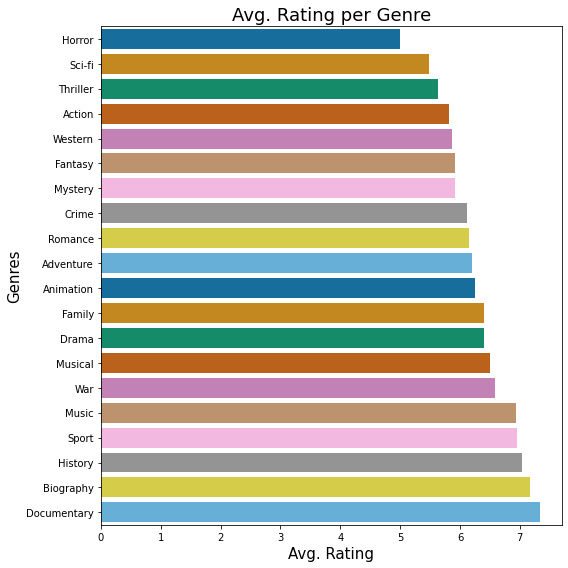

In [36]:
plt.figure(figsize=(8,8))
sns.barplot(x="Avg. Rating", y = "Genres", palette='colorblind', data=df1, errcolor='.95', order=df1.sort_values("Avg. Rating").Genres)
plt.xlabel("Avg. Rating", size=15)
plt.ylabel("Genres", size=15)
plt.title("Avg. Rating per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)


## Money per genre
- What is the best genre solely focused on how much money you can make?
- What genre is the "safest choice"? Less likely to lose money?
- What genre takes the least money to produce? And the most?


### - What is the best genre solely focused on how much money you can make?

In [37]:
df = pd.DataFrame({"ROI":avg_roi_per_genre, "Genres":listatest})

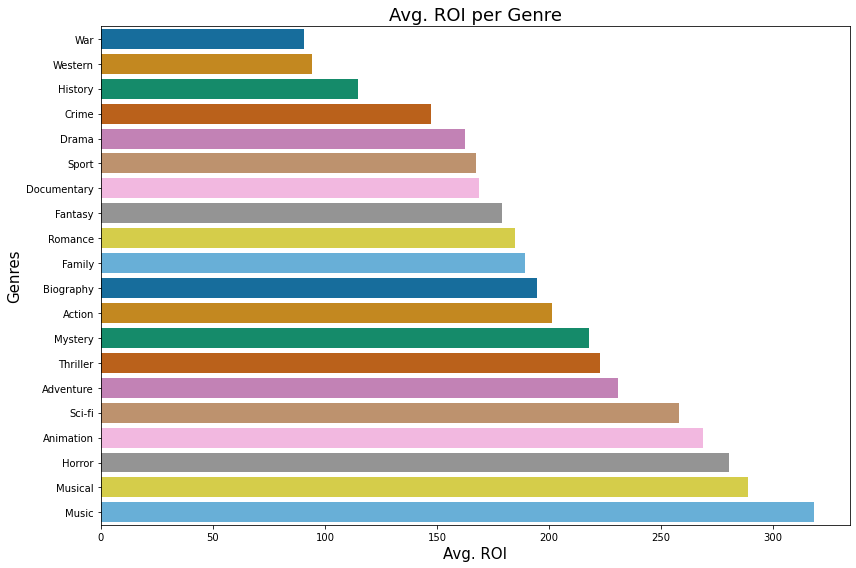

In [38]:
plt.figure(figsize=(12,8))
sns.barplot(x="ROI", y = "Genres", palette=('colorblind'),data=df, order=df.sort_values('ROI').Genres)
plt.xlabel("Avg. ROI", size=15)
plt.ylabel("Genres", size=15)
plt.title("Avg. ROI per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)

The answer? Animation followed by Horror

### - What genre is the safest choice?

So we are going to create a list that gives you a percentage of how likely you are to make or to lose money using the number of positive ROI's and the number of negative ROI's.

In [39]:
def how_safe(dataframe):
    '''
    This function gets the avarage(mean) rating based on the Genre
    '''
    positive_count = None
    negative_count = None
    if (dataframe['investment_return'] >= 0).bool():
        positive_count += 1
        total_count += 1
    else:
        total_count += 1
    
    return(positive_count/total_count)

# for roi in all_genre_df:
#     print(roi.investment_return)
    
#     testi = []
# for x in roi_list:
#     testi.append(x[0])
    

In [40]:
roi_list = []
for roi in all_genre_df:
    roi_list.append(roi['investment_return'])

In [41]:
positive_value = 0
total_value = 0
for x in roi_list[19]:
    if x > 0:
        positive_value += 1
        total_value += 1
    else:
        total_value += 1
print(positive_value/total_value)

0.4


In [42]:
chance_of_doing_well = [0.7368421052631579, 0.8174807197943444, 0.8632478632478633, 0.630057803468208, 0.6073825503355704, 0.6785714285714286, 0.6232006773920407, 0.7876106194690266, 0.7910447761194029, 0.5909090909090909, 0.6846153846153846, 0.6301369863013698, 0.4, 0.7159763313609467, 0.6814814814814815, 0.7375, 0.6041666666666666, 0.6675324675324675, 0.43, 0.38461538461538464]

In [43]:
df2 = pd.DataFrame({"Chances":chance_of_doing_well, "Genres":listatest})

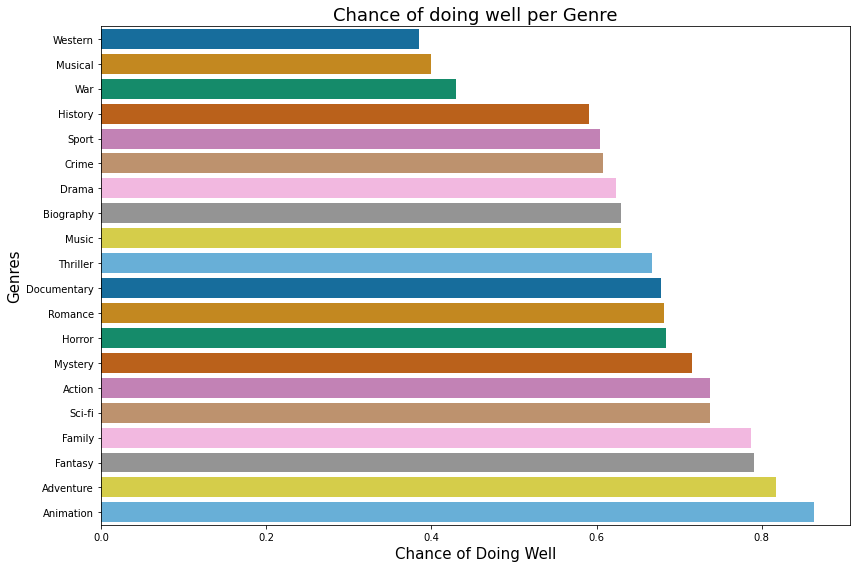

In [44]:
plt.figure(figsize=(12,8))
sns.barplot(x="Chances", y = "Genres",data=df2, palette='colorblind', order=df2.sort_values('Chances').Genres)
plt.xlabel("Chance of Doing Well", size=15)
plt.ylabel("Genres", size=15)
plt.title("Chance of doing well per Genre", size=18)
plt.tight_layout()
plt.savefig("barplot_Seaborn_Python.png", dpi=100)